In [1]:
import math
import os
import sys
import warnings

import matplotlib.pyplot as plt
import mud.funs as mdf
import numpy as np
import pandas as pd
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style("darkgrid")
sys.path.insert(0, os.path.dirname(os.getcwd()))

from dc_models.models import *
from dc_utils.plots import _create_paramdf, _plot_states, _print_dims

# # Statistics libraries
# from scipy.stats import uniform, norm
# from scipy.stats import gaussian_kde as GKDE

In [2]:
from distutils.spawn import find_executable

if find_executable("latex"):
    print("latex installed")

latex installed


## Mud estimation example for predator prey model

- Model: 
$$
\begin{aligned}
& \frac{d x}{d t}=\alpha x-\beta x y \\
& \frac{d y}{d t}=\delta x y-\gamma y
\end{aligned}
$$
where
- $x$ is the number of prey (for example, rabbits);
- $y$ is the number of some predator (for example, foxes);
- $\frac{d y}{d t}$ and $\frac{d x}{d t}$ represent the instantaneous growth rates of the two populations;
- $t$ represents time;
- $\alpha, \beta, \gamma, \delta$ are positive real parameters describing the interaction of the two species.

**Implementation Note/Issue:**

The given ode system has a two-dimensional state vector consisting of $x$ and $y$ and 4 separate parameters ($\lambda$'s) i.e. $\alpha, \beta, \gamma, \delta$ to estimate the mud points of.

### Parameter reduction

Note that the parameters $(\alpha, \beta, \gamma, \delta)$ are related as follows.
By the change of variables $x \rightarrow \hat{x}(\gamma/\delta)$, $y \rightarrow \hat{y}(\alpha/\beta)$, and $t \rightarrow \hat{t}/a$ we have:

$$
\begin{aligned}
& \frac{d \hat{x}}{d t}= \hat{x} - \hat{x}\hat{y} \\
& \frac{d \hat{y}}{d t}= \eta(-\hat{y} + \hat{x}\hat{y})
\end{aligned}
$$

Where 

$$
\eta = \gamma/\delta
$$

### Generate the samples from the forward model

In [3]:
def generate_forward_runs(model, args, nruns, state_samples):
    """ """
    for i in range(nruns):

        if model.__eq__("lv"):
            m = lotka_volterra(**args)
        else:
            m = None

        m._run_model()
        states, params, times = m._get_outputs()
        states_dim = states.shape

        if i == 0:
            runs = states[:, :: (states_dim[1] // state_samples), :]
            pdims = params.shape
            lambdas = np.zeros([nruns, pdims[0], pdims[1]])
            lambdas[0, :, :] = params

        else:
            runs = np.append(
                runs, states[:, :: (states_dim[1] // state_samples), :], axis=0
            )
            lambdas[i, :, :] = params

    return runs, lambdas

### Generate true parameter values to be estimated for $\alpha, \beta, \gamma, \delta$

- Note we initially set drift_windows and assim_windows = 1 to attempt a non-sequential data-consistent inversion problem before attempting sequential estimation
- Initially set the true values of all four paramters to 0.5 for simplicity
- Let *state_samples* be the output of our observation operator (or number of observations), which in this case will be 50
- Let *num_samples* be the number of forward runs of our model, which will be 100 for this example

In [72]:
# mud parameters
total_timesteps = 1000 # Total timesteps to simulate
num_timesteps = 500    # number of samples to take from true state trajectory
num_samples = 1000      # number of samples to draw per parameter

true_args = {
    "state_init": np.array([4, 2]),
    "true_model": True,
    "num_tsteps": total_timesteps,
    "tend": 200,
    "num_parameters": 4,
    "lambda_true": [0.5] * 4,
    "supports": [[0, 1]] * 4,
    "drift_windows": 1,
    "assim_windows": 1,
}

true_states, true_lambdas = generate_forward_runs("lv", true_args, 1, num_timesteps)
true_states.shape, true_lambdas.shape
true_states[0].shape

(500, 2)

#### Phase Plot

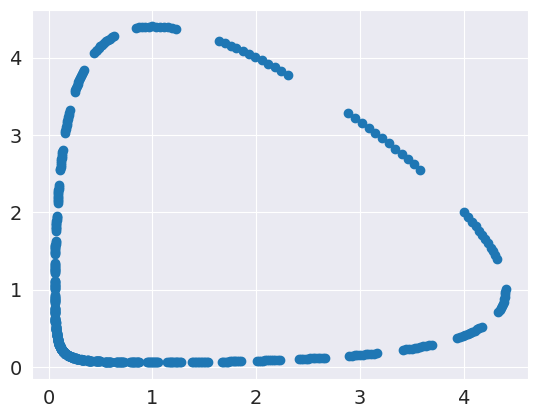

In [73]:
plt.scatter(true_states[0][:, 0], true_states[0][:, 1])

### Generate parameter predictions for $\alpha, \beta, \gamma, \delta$

- Note the support we use (domain) influences greatly the size of the parameter space we are searching for
- The greater the domain, the more difficult the parameter estimation problem will be, especially since we are using density estimation to solve the data-consistent inversion problem. With a four parameter problem, the density estimation requires a lot of samples and data.
- If we refine the domain of our search to be closer around the true value we make the problem more tractable.

In [76]:
# domain = [0, 1]     # VERY HARD
domain = [0.3, 0.8] # HARD
# domain = [0.4, 0.6] # DO-ABLE
predict_args = {
    "state_init": np.array([4, 2]),
    "true_model": False,
    "num_tsteps": num_timesteps,
    "tend": 200,
    "num_parameters": 4,
    "supports": [domain] * 4,
    "drift_windows": 1,
    "assim_windows": 1,
}
predict_states, predict_lambdas = generate_forward_runs(
    "lv", predict_args, num_samples, num_timesteps
)

predict_states.shape, predict_lambdas.shape

((1000, 500, 2), (1000, 1, 4))

#### Phase Plot

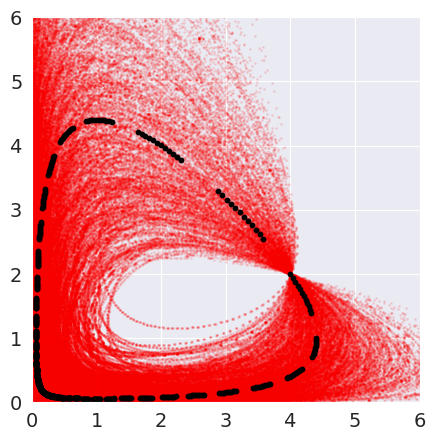

In [77]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)
for n in range(num_samples):
    ax.scatter(
        predict_states[n][:, 0], predict_states[n][:, 1], s=1, alpha=0.1, color="red"
    )
ax.set_ylim([0, 6])
ax.set_xlim([0, 6])
plt.scatter(true_states[0][:, 0], true_states[0][:, 1], color='black', s=10)

## Mud Estimation

#### SpatioTemporalProblem Class

Use  [`SpatioTemporalProblem`](http://github.com/mathematicalmichael/mud) class to aggregate all data available.

In [78]:
from mud.base import SpatioTemporalProblem as STP

data = {
    "sample_dist": "u",
    "domain": np.array(domain * 4),
    "sensors": np.array([[0, 0], [0, 0]]),
    "times": np.arange(0, num_timesteps),
    "lam_ref": true_lambdas.reshape(4, 1),
    "std_dev": 0.1,
    "true_vals": true_states[0],
    "lam": predict_lambdas.reshape(num_samples, 4),
    "data": predict_states,
}

spatio_temporal_data = STP(df=data)


#### Generating Measurements

Note that since we are constructing our real world measurements from true simulated values, we must first call the `measurements_from_reference()` function with an associated std_deviation to create simulated measurements for the parameter estimation problem.

In [80]:
# Generate artifical measurements from true values
sd = 1.5e-3
spatio_temporal_data.measurements_from_reference(std_dev=np.sqrt(sd), seed=21)

## Plotting Capabilities

Can see the data we have collected over time.

### Population x

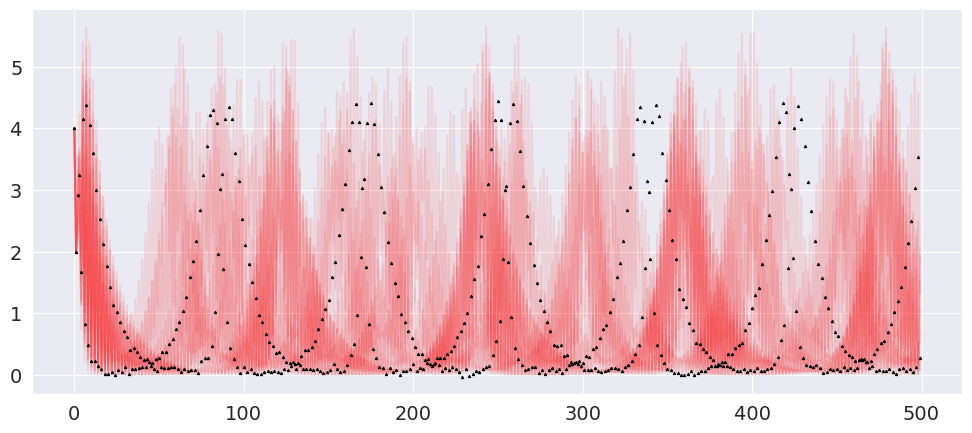

In [81]:
_ = spatio_temporal_data.plot_ts(max_plot=10)

### Population y

Note we can change for what observable we plot the time series as well

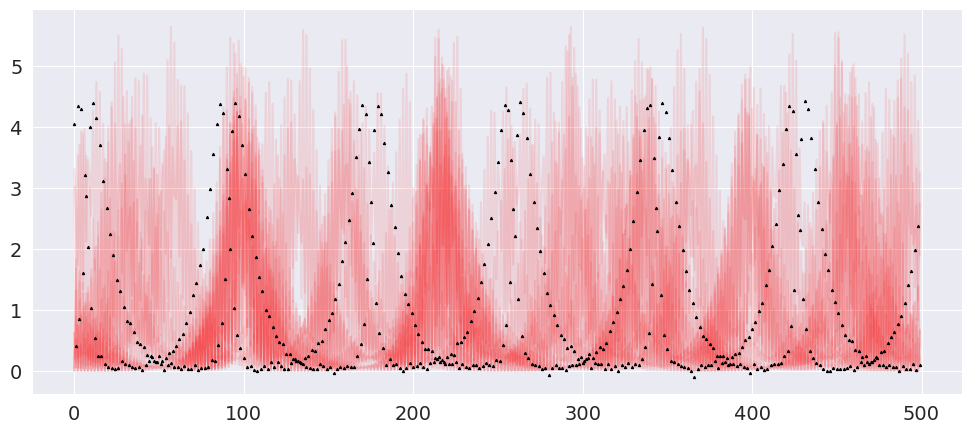

In [82]:
_ = spatio_temporal_data.plot_ts(sensor_idx=1, max_plot=10)

## Creating MUD problems from the data set to solve

Use the `mud_problem()` constructor to build a mud problem from a subset of the data available. 
Default method of aggregating the data is using the $Q_{PCA}$ map described in <cite id="f759w"><a href="#zotero%7C11450669%2FXY9A7B93">(Pilosov et al., 2022)</a></cite>.
Can vary the amount of components used with the `num_components` argument

**NOTE: Remember to always check $E(r)$ to judge the quality of your result. Use the method `expected_ratio()`**

In [83]:
mud_prob_1 = spatio_temporal_data.mud_problem(times_mask=np.arange(0,200), num_components=1)
mud_prob_2 = spatio_temporal_data.mud_problem(times_mask=np.arange(0,200), num_components=2)
mud_prob_3 = spatio_temporal_data.mud_problem(times_mask=np.arange(0,200), num_components=2)
[[mud_prob_1.estimate(), mud_prob_1.expected_ratio()],
 [mud_prob_2.estimate(), mud_prob_2.expected_ratio()],
 [mud_prob_3.estimate(), mud_prob_3.expected_ratio()]]

[[array([0.30731946, 0.53725967, 0.73568262, 0.69414593]), 1.3135764969375001],
 [array([0.52256624, 0.4404303 , 0.68153585, 0.69228312]),
  4.241762888518518e-10],
 [array([0.52256624, 0.4404303 , 0.68153585, 0.69228312]),
  4.06674894582264e-10]]

## Assimilating More Data

Comparing non-iterative vs iterative approach:

In [91]:
num_components = 1
start = 0
stop = 500                  # num_timesteps
interval_size = 10          # Size of intervals for iterative method
chunk_size = interval_size # size of chunks in non iterative (just aggregating data)

### Non-iterative approach

Just add data to mud_problem construction as it becomes available:

### Iterative Approach

Use previous r ratios as sample weights on next iterations:

#### Basic Idea

Illustrating here using only 1 principle component each iteration, and fixed timestep sizes of 50 timesteps. 
But in theory we could use variable time steps and number of components, and should. 
Want to check `expected_ratio()` at each iteration.

In [92]:
test_step_size = 100

##### Iteration 1

In [93]:
mud_prob_1 = spatio_temporal_data.mud_problem(times_mask=np.arange(0,test_step_size), num_components=num_components)
mud_prob_1.estimate(), mud_prob_1.expected_ratio()

(array([0.5451269 , 0.42096042, 0.47548863, 0.43470955]), 1.3098378405717819)

##### Iteration 2

We now want to use the r ratio to re-weight samples on the next iteration if we aren't re-sampling

In [94]:
mud_prob_1._r.shape, mud_prob_1._r[0:10]

((1000,),
 array([5.36149404e-144, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.03349459e-026, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 0.00000000e+000]))

In [95]:
mud_prob_2 = spatio_temporal_data.mud_problem(times_mask=np.arange(test_step_size,2*test_step_size),
                                              num_components=num_components,
                                              sample_weights=mud_prob_1._r)

In [96]:
mud_prob_2.estimate(), mud_prob_2.expected_ratio()

(array([0.42364515, 0.49569679, 0.71411238, 0.7345279 ]),
 1.0808801064828529e-05)

### Comparison Plots

In [97]:
ts_1  = np.arange(start=start, stop=stop, step=chunk_size, dtype=int)
chunk_estimates = []
chunk_e_rs = []
chunk_errs = []
for i in ts_1:
    mud_prob_i = spatio_temporal_data.mud_problem(times_mask=np.arange(start-chunk_size,i),
                                                  num_components=num_components)
    chunk_estimates.append(mud_prob_i.estimate())
    chunk_e_rs.append(mud_prob_i.expected_ratio())
    chunk_errs.append(np.linalg.norm(mud_prob_i.estimate() - true_lambdas))

In [98]:
chunk_avg_e_r = np.mean(chunk_e_rs)
chunk_avg_estimates = np.mean(np.array(chunk_estimates).reshape(len(ts_1), 4), axis=0)
avg_chunk_error = np.mean(chunk_errs)
std_chunk_error = np.std(chunk_errs)

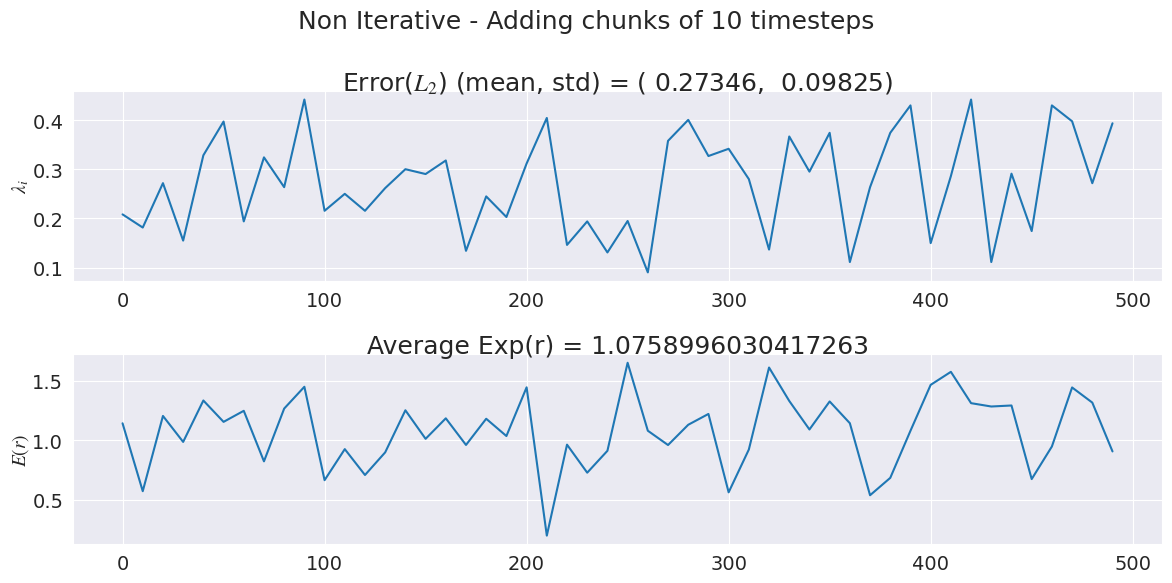

In [99]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ts_1, chunk_errs)
ax1.set_ylabel('$\lambda_i$', fontsize=14)
plt.title(f'Error($L_2$) (mean, std) = ({avg_chunk_error: 1.5f}, {std_chunk_error: 1.5f})', fontsize=18)
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(ts_1, chunk_e_rs)
ax2.set_ylabel('$E(r)$', fontsize=14)
plt.title(f'Average Exp(r) = {chunk_avg_e_r}', fontsize=18)
plt.suptitle(f'Non Iterative - Adding chunks of {chunk_size} timesteps', fontsize=18)
fig.tight_layout()

In [100]:
ts_1  = np.arange(start=start, stop=stop, step=interval_size, dtype=int)
int_estimates = []
int_e_rs = []
int_errs = []
weights = None
for idx, i in enumerate(ts_1[1:]):
    start_idx = 0 if idx == 0 else ts_1[idx-1]
    mud_prob_i = spatio_temporal_data.mud_problem(times_mask=np.arange(start_idx, i),
                                                  num_components=num_components, sample_weights=weights)
    weights = mud_prob_i._r
    int_estimates.append(mud_prob_i.estimate())
    int_e_rs.append(mud_prob_i.expected_ratio())
    int_errs.append(np.linalg.norm(mud_prob_i.estimate() - true_lambdas))

In [101]:
int_avg_e_r = np.mean(int_e_rs)
int_avg_estimates = np.mean(np.array(int_estimates).reshape(len(ts_1)-1, 4), axis=0)
avg_int_error = np.mean(int_errs)
std_int_error = np.std(int_errs)

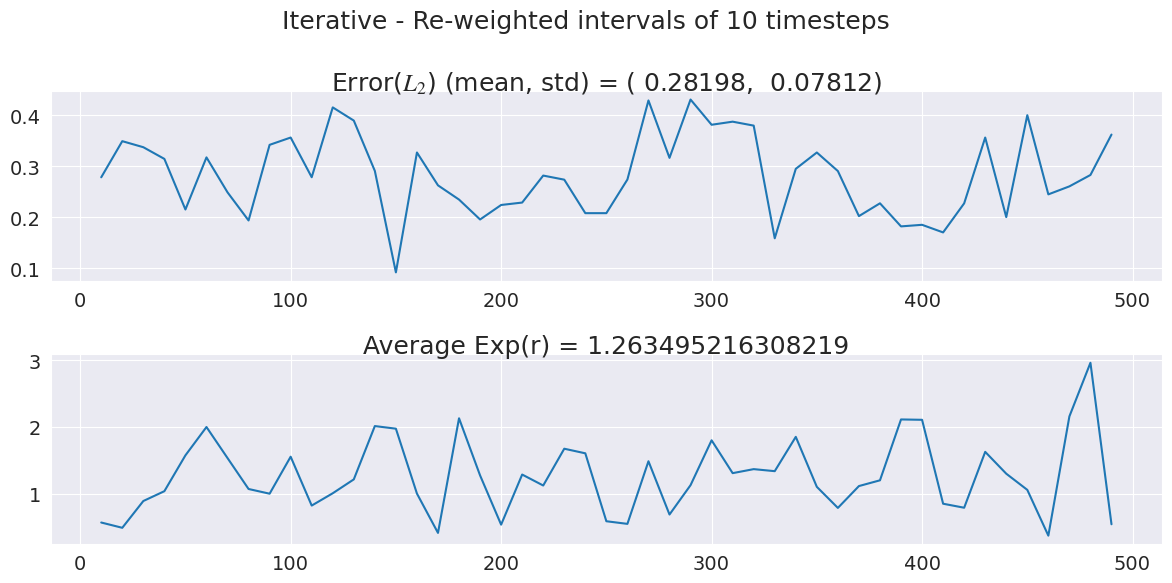

In [102]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(ts_1[1:], int_errs)
plt.title(f'Error($L_2$) (mean, std) = ({avg_int_error: 1.5f}, {std_int_error: 1.5f})', fontsize=18)
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(ts_1[1:], int_e_rs)
plt.title(f'Average Exp(r) = {int_avg_e_r}', fontsize=18)
plt.suptitle(f'Iterative - Re-weighted intervals of {chunk_size} timesteps', fontsize=18)
fig.tight_layout()

## Re-sampling iterations

TODO: re-sample from updated distributions between an iteration